<a href="https://colab.research.google.com/github/vmatiasw/modelos_y_simulacion/blob/main/P5E11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

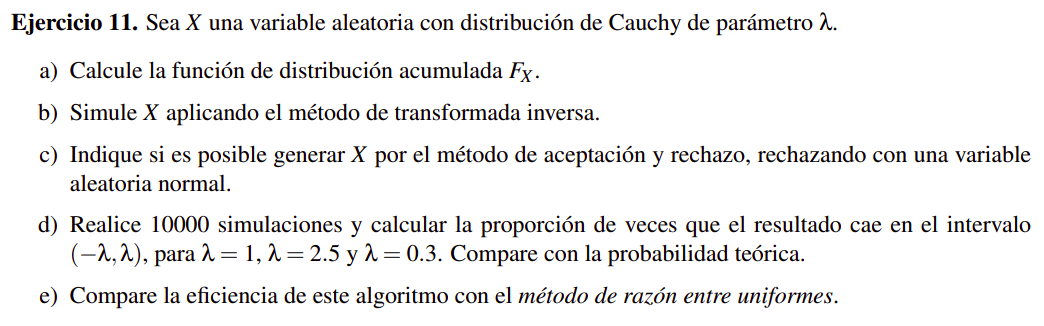

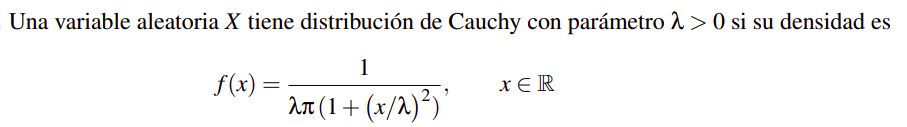

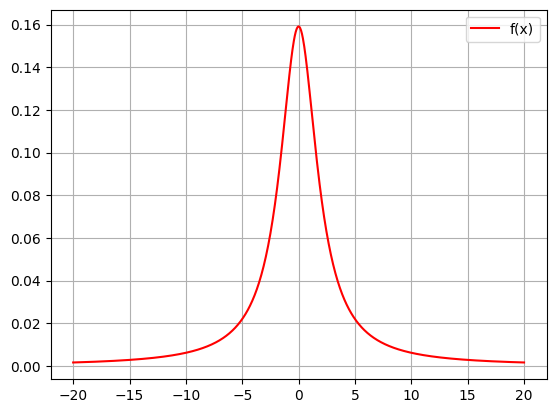

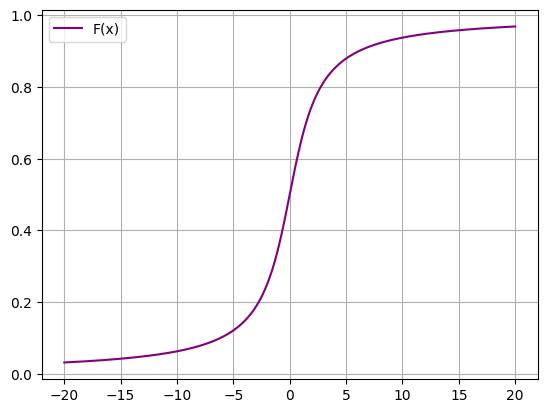

In [14]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NUMERO_DE_MUESTRAS = 100_000
LAMBDA = 2
X_MIN, X_MAX = -20, 20
DOMINIO = np.linspace(X_MIN, X_MAX, 1000)

def f_cauchy(x, l=LAMBDA):
  return 1 / (l * np.pi * (1 + (x/l)**2))

def F_cauchy(x, l=LAMBDA):
  return np.arctan(x/l) / np.pi + 0.5

#@title { vertical-output: true}
sns.lineplot(x=DOMINIO, y=f_cauchy(DOMINIO), label="f(x)", color="red")
plt.grid(True)
plt.legend()
plt.show()

sns.lineplot(x=DOMINIO, y=F_cauchy(DOMINIO), label="F(x)", color="purple")
plt.grid(True)
plt.legend()
plt.show()

## 8.b

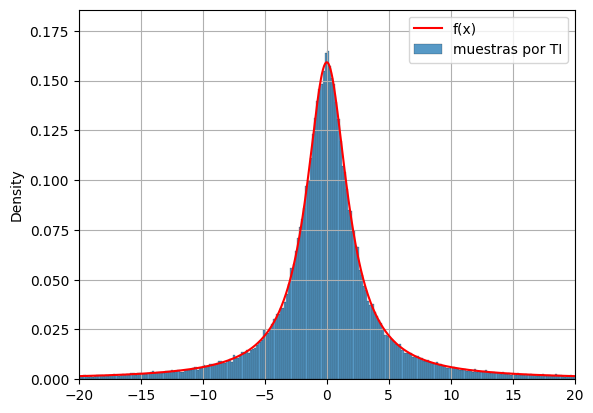

In [15]:
def muestreador_cauchy_TI():
  return np.tan(np.pi * (random() - 0.5)) * LAMBDA

muestras = [min(max(muestreador_cauchy_TI(), X_MIN-1), X_MAX+1) for _ in range(NUMERO_DE_MUESTRAS)]

#@title { vertical-output: true}
sns.lineplot(x=DOMINIO, y=f_cauchy(DOMINIO), label="f(x)", color="red")
sns.histplot(muestras, stat='density', label='muestras por TI')
plt.xlim(X_MIN, X_MAX)
plt.grid(True)
plt.legend()
plt.show()

## 8.c

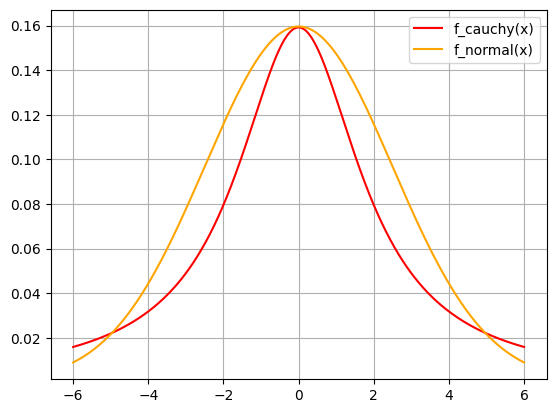

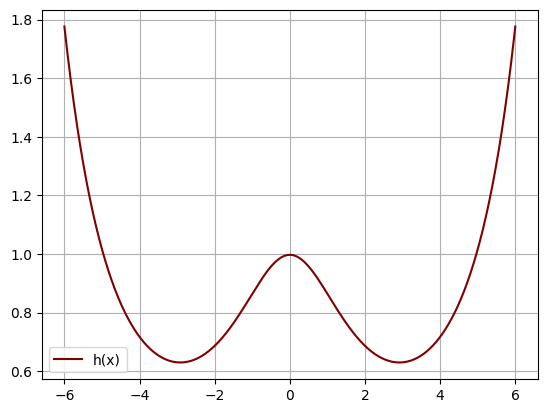

In [37]:
MU = 0
ALPHA = 2.5
DOM = np.linspace(-6, 6, 1000)

def f_normal(x, mu=MU, alpha=ALPHA):
  return (1 / (alpha * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * alpha**2))

def h(x):
  return f_cauchy(x) / f_normal(x)

#@title { vertical-output: true}
sns.lineplot(x=DOM, y=f_cauchy(DOM), label="f_cauchy(x)", color="red")
sns.lineplot(x=DOM, y=f_normal(DOM), label="f_normal(x)", color="orange")
plt.grid(True)
plt.legend()
plt.show()

sns.lineplot(x=DOM, y=h(DOM), label="h(x)", color="maroon")
plt.grid(True)
plt.legend()
plt.show()

## 8.d

In [38]:
P_entreL = sum([
    -LAMBDA < muestreador_cauchy_TI() < LAMBDA
    for _ in range(NUMERO_DE_MUESTRAS)
]) / NUMERO_DE_MUESTRAS

print("P(-L<=X<=L) = 0.5")
print("Estimacion: ", P_entreL)

P(-L<=X<=L) = 0.5
Estimacion:  0.49789


## 8.e

In [46]:
%%timeit
muestreador_cauchy_TI()

1.42 µs ± 367 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [48]:
# del ejercicio 10:
SEMICIRCLE_RADIUS = 1/np.pi**(1/2)  # Radio del semicírculo: √(1/π)
PI_INV = 1 / np.pi                # Inversa de π
SEMICIRCLE_AREA_BOUND = PI_INV   # Cota para el conjunto Cf: u² + v² < 1/π

def f(x, l=LAMBDA):
  return 1 / (l * np.pi * (1 + (x/l)**2))

# ReU o RoU en ingles

def muestreador_cauchy_ReU_optimo(l=LAMBDA):
  while True:
    u = random() * SEMICIRCLE_RADIUS
    v = (1-random()*2) * SEMICIRCLE_RADIUS
    if u**2 + v**2 < SEMICIRCLE_AREA_BOUND:
      return (v/u)  * l


def muestreador_cauchy_ReU_cmayor(l=LAMBDA):
  while True:
    u = random()
    v = (1-random()*2)
    if u**2 + v**2 < SEMICIRCLE_AREA_BOUND:
      return (v/u)  * l


def muestreador_cauchy_ReU_confx(l=LAMBDA):
  while True:
    u = random() * SEMICIRCLE_RADIUS
    v = (1-random()*2) * SEMICIRCLE_RADIUS
    if u**2 < f(v/u, l=1):
      return (v/u)  * l

In [45]:
%%timeit
muestreador_cauchy_ReU_optimo()

502 ns ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [49]:
%%timeit
muestreador_cauchy_ReU_cmayor()

1.45 µs ± 345 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [50]:
%%timeit
muestreador_cauchy_ReU_confx()

817 ns ± 7.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


chatGPT:
La primera versión (RoU) es más rápida que la segunda (TI, transformación inversa) porque evita cálculos costosos como funciones trigonométricas (tan y π * x), usando solo multiplicaciones, divisiones y comparaciones simples — que son mucho más eficientes a nivel de CPU.

| Operación                | Costo relativo | Detalles técnicos                                                                 |
|--------------------------|----------------|------------------------------------------------------------------------------------|
| `+`, `-`, `*`, `<`, `>`, `==` | 1×             | Operaciones básicas de punto flotante (IEEE-754), muy baratas.                   |
| `/`, `**2`               | 2×             | División es más costosa; elevar al cuadrado suele ser `x * x` (2 ops).           |
| `c * x` (constante genérica) | 1–2×           | Mismo costo que `*`; solo es más si implica más precisión o no se optimiza bien. |
| `c * x` (potencia de 2)  | ~1×            | Puede optimizarse como shift binario (`x * 2ⁿ`), muy barato si el compilador lo hace. |
| `π * x`, `e * x`         | 1–2×           | Igual que `c * x`; π y e se almacenan como `float64`, sin costo extra.           |
| `random()` (uniforme)    | 3–5×           | Depende del generador (`random()`, `np.random`, etc.), genera bits aleatorios.   |
| `sqrt(x)`                | 5–10×          | Más costosa, pero optimizada en CPU modernas (instrucción especial).             |
| `log(x)`, `exp(x)`       | 10–20×         | Lentas, pero frecuentes en simulación y ML.                                      |
| `sin(x)`, `cos(x)`       | 15–40×         | Trigonométricas más rápidas que `tan`, pero siguen siendo caras.                 |
| `tan(x)`                 | 20–50×         | Muy costosa, con puntos problemáticos (asíntotas); riesgo de overflow.           |
| `arctan(x)`              | 20–60×         | Más costosa que `tan`; común en algunos métodos estadísticos.                    |
| `np.tan(x)`              | 25–60×         | Más lento que `math.tan(x)` por verificación de tipos y manejo de arrays.        |

Se asume que no hay vectorización ni compilación (pure Python, sin NumPy, Numba, Cython, etc.).

random() puede diferir mucho según si es el de random, numpy.random, secrets, etc